## Solution of homework 1

The next line activates the environment in which we are working on HW1. It is assumed that you already generated this environment, per the instructions in the document *UsingJulia.pdf*

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/HW1")

"/Users/jeff/Dropbox/MAE250H/julia/HW1/Project.toml"

These load in some packages. The first package (Revise) allows us to make immediate use of the code after we have changed it. This avoids the need to restart the Julia session every time we change code. The second line loads our HW1 module.

In [2]:
using Revise
using HW1

Let's read the documentation that we wrote for scale_it

In [3]:
?HW1.scale_it

```
scale_it(f::Function,x::Real,c::Real) -> Real
```

Takes as input a function `f` and two real-valued arguments `x` and `c` and returns value `c*f(x)`.

For example,

```
julia> g(x) = x^2

julia> HW1.scale_it(g,1,2)
2
```


Okay, so let's try it! First we define a function for input. We can call it anything we want:

In [4]:
fcn(x::Real) = tan(x)

fcn (generic function with 1 method)

Now let's try it out. Here, we will double the result of the tangent:

In [5]:
HW1.scale_it(fcn,pi/4,2)

1.9999999999999998

#### Plotting

We will make use of the Plots package. It is presumed that you already added this package.

In [7]:
using Plots

Let's try evaluating our scale_it function on a vector of data:

In [8]:
x = range(0,pi/4,length=101)

0.0:0.007853981633974483:0.7853981633974483

We can't just pass `x` in, because it only accepts scalar arguments. But in Julia, we can use the . notation to get a vectorized form of the function:

In [9]:
HW1.scale_it.(fcn,x,2)

101-element Array{Float64,1}:
 0.0                
 0.01570828625796718
 0.03141851064732983
 0.0471326122561293 
 0.0628525320867023 
 0.07858021401533928
 0.09431760575496094
 0.11006665982182706
 0.12582933450729952
 0.14160759485569036
 0.15740341364923688
 0.17321877240125833
 0.18905566235856408
 ⋮                  
 1.6811756375362736 
 1.7081613709269332 
 1.7355115938216823 
 1.7632371847263781 
 1.7913494167409458 
 1.819859976355475  
 1.848780983316414  
 1.8781250116349844 
 1.9079051118155266 
 1.9381348343875864 
 1.9688282548321938 
 1.9999999999999998 

Let's plot the result:

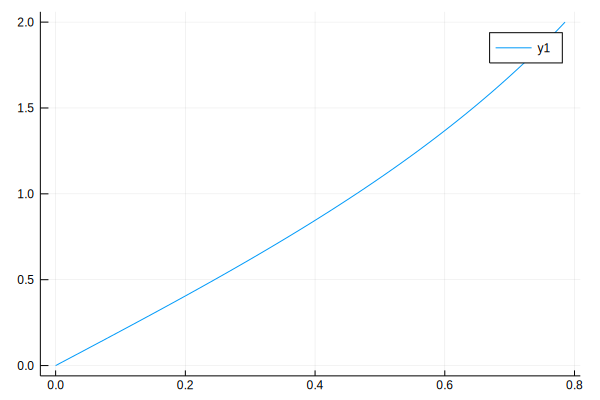

In [10]:
plot(x,HW1.scale_it.(fcn,x,2))

### Testing the circulant triadiagonal matrix solver

In [11]:
?HW1.trisolve

```
trisolve(a,b,c,f::Vector{<:Real},sys_type::String) -> Vector{Real}
```

Solve a tridiagonal system, in which the matrix consists of elements `a`, `b`, and `c`, on the subdiagonal, diagonal, and superdiagonal, respectively, and the right-hand side of the system is given by vector `f`. The `sys_type` of system can be either `"circulant"` or `"regular"`. The solution is returned as a vector the same size as `f`.

For `"circulant"` systems, `a`, `b` and `c` can only be scalars, since the diagonals must each be uniform. For `"regular"` systems, these can each be vectors, but `b` must be the same length as `f` and `a` and `c` should be one element shorter.


Okay, let's try it! First on a circulant type system:

In [12]:
a = 1; b = 4; c = 1
M = 4 
rhs = sin.(π*(0:M-1)/M)

4-element Array{Float64,1}:
 0.0               
 0.7071067811865475
 1.0               
 0.7071067811865476

In [13]:
HW1.trisolve(a,b,c,rhs,"circulant")

4-element Array{Float64,1}:
 -0.07618446353109125
  0.15236892706218247
  0.17381553646890874
  0.15236892706218247

Is that the right answer? Let's compare it to what Julia gives using the built-in \ solver. There is a package called ToeplitzMatrices that can help us easily produce a circulant matrix

In [14]:
using ToeplitzMatrices

In [18]:
v = zeros(M)
v[1] = b; v[2] = a; v[M] = c
A = Circulant(v)
A\rhs

4-element Array{Float64,1}:
 -0.07618446353109125
  0.15236892706218247
  0.17381553646890874
  0.15236892706218247

#### Profile the code

Let's time the code to see how long it takes. We will use a bigger system for this:

In [19]:
N = 10000
a = rand(); b = rand(); c = rand()
rhs = rand(N);

We use `@time` for timing this. We sometimes have to run it more than once to get a proper estimate of time, since the first time includes some compilation time.

In [22]:
@time HW1.trisolve(a,b,c,rhs,"circulant");

  0.001302 seconds (122 allocations: 793.531 KiB)


For deeper code profiling (to see where the code spends most of its time), we can use the Profile package

In [23]:
using Profile

Clear the profile buffer

In [24]:
Profile.clear()

Run the profiler. To get more statistics, run the code lots of times.

In [25]:
@profile (for i = 1:1000; HW1.trisolve(a,b,c,rhs,"circulant"); end) 

Now look at the profiler results. The first number indicates how many times the code was on a particular line of code for each sample. Larger numbers mean more time spent on that particular line. The code's nesting is indicated by indentation. Here, we look down for places in the actual trisolve function it spent its time. It spends most of its time on generating the eigenvalues.

In [26]:
Profile.print()

1025 ./task.jl:259; (::getfield(IJulia, Symbol("##15#1...
 1025 ...9ajf8/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  1025 ./essentials.jl:741; invokelatest
   1025 ./essentials.jl:742; #invokelatest#1
    1025 ...c/execute_request.jl:67; execute_request(::ZMQ.Socket, ::...
     1025 .../SoftGlobalScope.jl:218; softscope_include_string(::Modu...
      1025 ./boot.jl:328; eval
       1025 ./In[25]:1; top-level scope
        1025 ...file/src/Profile.jl:25; macro expansion
         1025 ./In[25]:1; macro expansion
          2    ./simdloop.jl:0; trisolve(::Float64, ::Float6...
          10   ...lia/HW1/src/HW1.jl:87; trisolve(::Float64, ::Float6...
           10 ./broadcast.jl:753; materialize
            10 ./broadcast.jl:773; copy
             10 ./broadcast.jl:797; copyto!
              2 ./broadcast.jl:853; copyto!
               2 ./boot.jl:402; Type
              8 ./broadcast.jl:857; copyto!
               8 ./simdloop.jl:73; macro expansion
                7 ./broadcast.jl:858; m

                     1 ./special/trig.jl:82; sin_kernel
                      1 ./float.jl:399; *
                    6  ./special/trig.jl:38; sin(::Float64)
                     1 ./float.jl:557; isinf
                      1 ./float.jl:448; isfinite
                    19 ./special/trig.jl:41; sin(::Float64)
                     5 ...al/rem_pio2.jl:0; rem_pio2_kernel
                     3 ...al/rem_pio2.jl:219; rem_pio2_kernel
                      3 ./math.jl:1052; poshighword
                       2 ./essentials.jl:381; reinterpret
                       1 ./int.jl:297; poshighword
                     2 ...al/rem_pio2.jl:231; rem_pio2_kernel
                      1 ...al/rem_pio2.jl:52; cody_waite_2c_pio2
                       1 ./float.jl:404; muladd
                      1 ...al/rem_pio2.jl:53; cody_waite_2c_pio2
                       1 ./float.jl:404; muladd
                     1 ...al/rem_pio2.jl:238; rem_pio2_kernel
                      1 ./float.jl:404; cody_waite_2c_p

                  51 ...7sLQ/src/fft.jl:626; #plan_bfft!#10
                   2  ...7sLQ/src/fft.jl:498; FFTW.cFFTWPlan{Complex{F...
                    2 ...7sLQ/src/fft.jl:449; dims_howmany(::Array{Com...
                     1 ./essentials.jl:674; append_any(::Any, ::Var...
                   49 ...7sLQ/src/fft.jl:499; FFTW.cFFTWPlan{Complex{F...
           5   ...ia/HW1/src/HW1.jl:139; circulant(::Float64, ::Float...
            5 ./broadcast.jl:756; materialize!
             5 ./broadcast.jl:797; copyto!
              5 ./broadcast.jl:842; copyto!
               2 ./simdloop.jl:71; macro expansion
                1 ./int.jl:49; <
               3 ./simdloop.jl:73; macro expansion
                3 ./broadcast.jl:843; macro expansion
                 3 ./broadcast.jl:511; getindex
                  3 ./broadcast.jl:551; _broadcast_getindex
                   3 ./broadcast.jl:578; _broadcast_getindex_evalf
                    3 ./complex.jl:312; *
                     3 ./promotion

### Testing regular tridiagonal matrices

In [27]:
using LinearAlgebra

In [28]:
M = 1000
P = 1
rhs = 6sin.(P*π*(1:M)/(M+1))
a = 1; b = 4; c = 1;

Now use our solver. We will time it to see how long it takes. Run this more than once, because the first run includes compilation time.

In [29]:
@time soln_ours = HW1.trisolve(a,b,c,rhs,"regular");

  0.000040 seconds (15 allocations: 60.188 KiB)


Now let's use the Julia \ solver. We first need to construct the tridiagonal matrix:

In [31]:
A = Tridiagonal(fill(1,M-1),fill(4,M),fill(1,M-1));
@time soln_julia = A\rhs;

  0.000035 seconds (13 allocations: 47.906 KiB)


Let's check that they give the same answer. We will use the Linf norm, which is simply the maximum absolute value (of the difference of vectors)

In [32]:
norm(soln_ours - soln_julia,Inf)

4.440892098500626e-16

Now let's evaluate the computational time vs length of vector

In [33]:
N = 2 .^(10:25)
cputime = []
for Ni in N
    rhs = 6sin.(P*π*(1:Ni)/(Ni+1))
    val, cputmp = @timed soln_ours = HW1.trisolve(a,b,c,rhs,"regular")
    push!(cputime,cputmp)
end

Plot the cpu time vs length on a log-log scale to reveal the scaling. Here, we can see that the time scales linearly with the length of the vector, which is ideal.

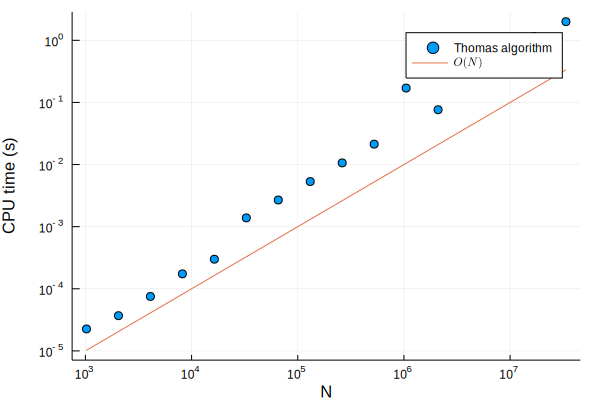

In [34]:
plot(N,cputime,xscale=:log10,yscale=:log10,seriestype=:scatter,label="Thomas algorithm")
plot!(N,1e-8*N,xscale=:log10,yscale=:log10,label="\$O(N)\$",xlabel="N",ylabel="CPU time (s)")

### Testing the numerical integration

In [35]:
c1 = 1
c2 = 100
α1 = 0.01
α2 = 0.3
δ = sqrt(0.001)
fcn(x::Real) = c1/sqrt(x+α1) + c2/((x-α2)^2+δ^2) - π
Ifcn = 2*c1*(sqrt(1+α1)-sqrt(α1)) + c2/δ*(atan(α2/δ) - atan((α2-1)/δ))-π

9458.389637191443

In [36]:
HW1.numerical_integrate(fcn,0,1,"trapezoidal",N=16)

9682.540941996644

In [37]:
N = [16,32,64,128,256,512,1024,2048,4096]
errtrap = []
errsimp = []
for Ni in N
    Ii = HW1.numerical_integrate(fcn,0,1,"trapezoidal",N=Ni)
    push!(errtrap,abs(Ii-Ifcn))
    Ii = HW1.numerical_integrate(fcn,0,1,"simpson",N=Ni)
    push!(errsimp,abs(Ii-Ifcn))
end

The plot below shows the error scalings of both algorithms. For small values of N it is a complicated mix, but as N increases the true scaling sorts itself out: 1/N^2 for trapezoidal and 1/N^4 for Simpson's rule

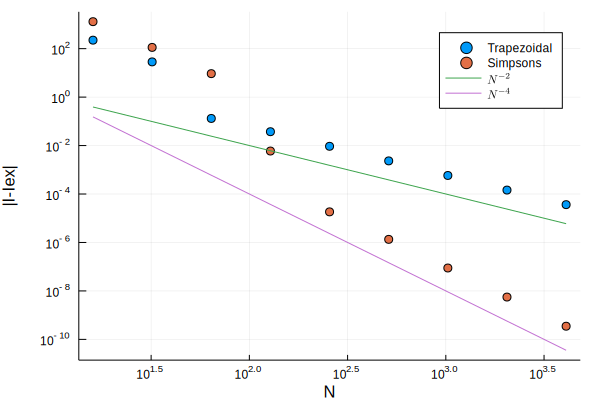

In [38]:
plot(N,errtrap,xscale=:log10,yscale=:log10,seriestype=:scatter,label="Trapezoidal")
plot!(N,errsimp,xscale=:log10,yscale=:log10,seriestype=:scatter,label="Simpsons", xlabel="N", ylabel="|I-Iex|")
plot!(N,100*N.^(-2),xscale=:log10,yscale=:log10,label="\$N^{-2}\$")
plot!(N,10000*N.^(-4),xscale=:log10,yscale=:log10,label="\$N^{-4}\$")